# STAT 301 Final Group Report

In [1]:
suppressWarnings(suppressMessages({
  library(AER)
  library(boot)
  library(broom)
  library(caTools)
  library(caret)
  library(cowplot)
  library(dplyr)
  library(ggplot2)
  library(GGally)
  library(glmnet)
  library(grid)
  library(gridExtra)
  library(infer)
  library(modelr)
  library(pROC)
  library(repr)
  library(doParallel)
  library(reshape2)
  library(tidyverse)
}))


cat("All necessary packages have been loaded successfully.")

All necessary packages have been loaded successfully.

# Title

Group Members:
- Vivaan Jhaveri (39723044)
- Ethan Rajkumar
- Michael Wang (32981300)
- Ruhani Kaur

## Introduction

Employee turnover is a critical challenge for organizations, with far-reaching consequences for productivity, morale, and financial performance. High turnover rates not only increase recruitment and training costs but also disrupt team dynamics and result in the loss of institutional knowledge. Retaining skilled employees is also essential for maintaining a competitive edge. Understanding the factors that drive employee turnover is key to developing effective retention strategies, making this a vital area of study for both practitioners and researchers.

Extensive prior research has identified key predictors of employee turnover, including job satisfaction, organizational commitment, and external job opportunities. Alkahtani (2015) highlights seven critical factors influencing turnover, such as perceived organizational support, supervisor support, and organizational justice. Kanchana and Jayathilaka (2023) demonstrated the significant impact of gender, age, and managerial interaction on turnover, emphasizing the importance of fostering employee engagement. Similarly, Alkaabi et al. (2024) underscored the roles of leadership efficacy, corporate culture, and career advancement opportunities, advocating for strategies such as leadership development programs and flexible work schedules to mitigate turnover risks.

Building on this foundation, this report will use the `Employee` dataset, a comprehensive resource containing anonymized data on 4,653 employees. The dataset, sourced from Kaggle, provides information on employee demographics, job characteristics, and work status within the organization.

The nine key variables in this dataset include:
- `Education`: Categorical variable representing the highest level of education attained by the employee ("Bachelors" "Masters", "PhD").
- `JoiningYear`: Numerical variable representing the year the employee joined the company.
- `City`: Categorical variable representing the city where the employee is located ("New Delhi", "Bangalore" "Pune").
- `PaymentTier`: Categorical variable representing the different salary tiers (1, 2, 3).
- `Age`: Numerical variable representing the age of the employee.
- `Gender`: Categorical variable representing the gender of the employee ("Male", "Female").
- `EverBenched`: Categorical (binary) variable representing whether the employee has ever been "benched" ("Yes") or not ("No").
- `ExperienceInCurrentDomain`: Numerical variable representing years of experience the employee has.
- `LeaveOrNot`: Binary response variable representing whether the employee left the company (1) or stayed (0).

This dataset provides a framework for identifying the factors that influence employee retention. By analyzing variables such as compensation(`PaymentTier`), benching status(`EverBenched`), and professional experience(`ExperienceInCurrentDomain`) and more, we aim to uncover actionable insights into turnover dynamics.

Our research employs logistic regression alongside ridge and lasso regression to predict employee turnover and assess the relative importance of key predictors. Logistic regression offers interpretability and identifies significant predictors, while ridge and lasso regression introduce regularization to address multicollinearity and improve model performance. This approach allows us to address the following questions:
1. How can logistic regression, logistic regression with ridge regularization, and logistic regression with lasso regularization be used to predict employee turnover? 
2. Moreover, how do these methods compare in their ability to identify influential factors, provide model interpretability, and achieve predictive performance?

By addressing these questions, our study contributes to the ongoing discourse on employee retention, providing practical strategies for organizations to build more stable and engaged workforces. The findings aim to guide HR professionals in designing data-driven interventions to improve employee satisfaction and reduce turnover.

## Methods and Results

### Exploratory Data Analysis (EDA)

- Demonstrate that the dataset can be read into R.
- Clean and wrangle your data into a tidy format.
- Plot the relevant raw data, tailoring your plot to address your question.
- Make sure to explore the association of the explanatory variables with the response.
- Any summary tables that are relevant to your analysis.
- Be sure not to print output that takes up a lot of screen space.
- Your EDA must be comprehensive with high quality plots.

The dataset will be split into training and testing subsets to ensure proper model evaluation and reduce overfitting. The training data (`employee_train.csv`) is used for exploratory data analysis, while the test data (`employee_test.csv`) will later be used to evaluate the model's performance. The `LeaveOrNot` variable is converted into a factor to facilitate analysis across different levels. Numerical and categorical variables are separated to ensure proper visualizations and statistical summaries.

In [ ]:
# Main developer: Ethan Rajkumar
# Contributor: Vivaan Jhaveri, Michael Wang, Ruhani Kaur

employee_train  <- read.csv("data/employee_train.csv")
employee_test <- read.csv("data/employee_test.csv") 

Let's visualize `employee_train` by taking a look at the categorical variables and the box plot medians. 

In [ ]:
# Main developer: Ethan Rajkumar
# Contributor: Vivaan Jhaveri, Michael Wang, Ruhani Kaur

options(warn = -1)
# Ensure 'LeaveOrNot' is a factor for proper grouping
employee_train <- employee_train %>%
  mutate(LeaveOrNot = as.factor(LeaveOrNot))

# Calculate variance for each numerical variable by LeaveOrNot
numeric_vars <- employee_train %>% select(where(is.numeric), LeaveOrNot)

numeric_vars_names <- names(numeric_vars)

categorical_vars <- employee_train %>% select(-numeric_vars_names, -LeaveOrNot)
categorical_vars$LeaveOrNot <- employee_train$LeaveOrNot

#### Cardinality Plots
The following cardinality plots are generated for categorical variables and display the proportion of employees who stayed versus left.

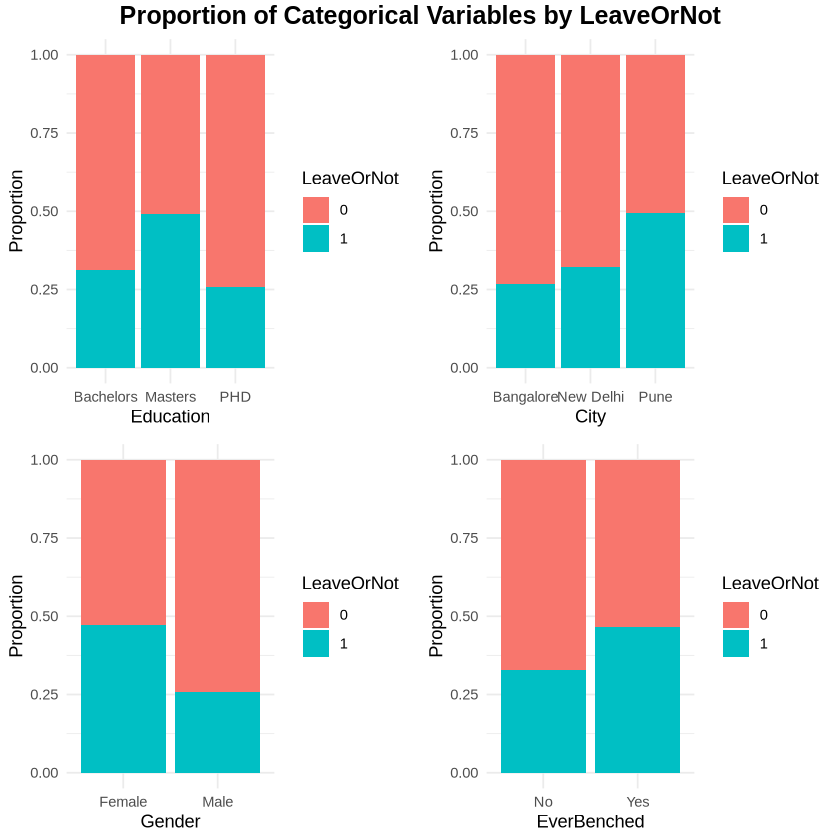

In [ ]:
# Main developer: Ethan Rajkumar

cardinality_plots <- lapply(names(categorical_vars)[-ncol(categorical_vars)], function(var) {
  ggplot(categorical_vars, aes(x = .data[[var]], fill = LeaveOrNot)) +
    geom_bar(position = "fill") +
    labs(x = var, y = "Proportion") +
    theme_minimal()
})

grid.arrange(
  grobs = cardinality_plots, 
  ncol = 2,  # Adjust as needed for layout
  top = textGrob("Proportion of Categorical Variables by LeaveOrNot", 
                 gp = gpar(fontsize = 15, fontface = "bold"))  # Customize title size and style here
)

#### Box Plots for Numerical Variables
The following boxplots are generated to explore the distribution and central tendency of numerical variables.

In [ ]:
# Main developer: Ethan Rajkumar

box_plots <- lapply(names(numeric_vars)[-ncol(numeric_vars)], function(var) {
  ggplot(numeric_vars, aes(x = factor(LeaveOrNot), y = .data[[var]], fill = factor(LeaveOrNot))) +
    geom_boxplot() +
    theme_minimal()
})

grid.arrange(
  grobs = box_plots,
  ncol = 2,  # Adjust layout as needed
  top = textGrob("Box Plots of Numeric Variables by LeaveOrNot",
                 gp = gpar(fontsize = 15, fontface = "bold"))
)

#### Pairwise Plots
The following pairwise plots are generated to visualize the relationships and potential multicollinearity between numerical predictors.

In [ ]:
# Main developer: Ethan Rajkumar

options(repr.plot.width = 12, repr.plot.height = 9)

# Create ggpairs plot for all numeric variables
ggpairs(numeric_vars,
        aes(color = LeaveOrNot, fill = LeaveOrNot), 
        title = "Pairwise Relationships of Numeric Variables by LeaveOrNot",
        upper = list(continuous = wrap("cor", size = 4)), 
        lower = list(continuous = wrap("points", alpha = 0.3, size = 1)), 
        diag = list(continuous = wrap("densityDiag"))) 

#### Summary of EDA
Correlation values in the plot indicate that `Age` and `ExperienceInCurrentDomain` have negative relationships with `LeaveOrNot`, suggesting that younger employees and those with less domain experience are more likely to leave. Density plots reveal that employees who joined more recently (indicated by peaks in the most recent years) show a higher likelihood of leaving. Scatterplots and histograms help visualize the distribution and clustering within each variable, reinforcing that employees with an earlier `JoiningYear`, higher `Age`, and more `ExperienceInCurrentDomain` tend to stay (red section). The box plots further support these trends by illustrating higher medians for `JoiningYear`, `Age`, and `ExperienceInCurrentDomain` among employees who stayed. 

After exploring all eight input variables, we conclude that `Education`, `Gender`, `PaymentTier`, `City`, and `EverBenched` may be strong predictors of `LeaveOrNot`, while `Age`, `JoiningYear`, and `ExperienceInCurrentDomain` seem less relevant due to apparent multicollinearity. Since this is merely an exploration of the variables without conducting a proper logistic regression, ridge and lasso regression these conclusions are speculative.

Based on these insights, we will proceed to design models for logistic regression, lasso regression, and ridge regression.  

### Methods: Plan

- Describe in written English the methods you used to perform your analysis from beginning to end, and narrate the code that does the analysis.
- If included, describe the “Feature Selection” process and how and why you choose the covariates of your final model.
- Make sure to interpret/explain the results you obtain. It’s not enough to just say, “I fitted a linear model with these covariates, and my R-square is 0.87”.
- If inference is the aim of your project, a detailed interpretation of your fitted model is required, as well as a discussion of relevant quantities (e.g., are the coefficients significant? How does the model fit the data)?
- A careful model assessment must be conducted.
- If prediction is the project's aim, describe the test data used or how it was created.
- Ensure your tables and/or figures are labelled with a figure/table number.

#### Main Models
To predict employee turnover (`LeaveOrNot`), the following models will be employed:
1. Logistic Regression:
    - A baseline model to predict the binary outcome (0 = stayed, 1 = left).
    - Provides interpretability through coefficient estimates, indicating the magnitude and direction of each predictor's effect on turnover.
2. Lasso Regression:
    - Employs L1 regularization to perform variable selection by shrinking some coefficients to zero.
    - Useful for identifying key predictors, especially when multicollinearity is present.
3. Ridge Regression:
    - Utilizes L2 regularization to mitigate multicollinearity and reduce overfitting.
    - Ensures robust model performance by balancing bias and variance.

### Potential Limitations
- **Linearity Assumption**: Logistic regression assumes a linear relationship between predictors and the log-odds of the outcome. Violations of this assumption can lead to model misspecification.
- **Class Imbalance**: The dataset has a higher proportion of employees staying (n=3053) compared to those leaving (n=1600), potentially biasing predictions toward the majority class.
- **Overfitting**: Including too many predictors without regularization can lead to overfitting. While ridge and lasso address this, careful tuning of their hyperparameters is essential to avoid under- or over-penalization.
- **Optimization Bias**: Ridge and lasso regularization, may lead to optimization bias. This can result in overly optimistic estimates of AUC that do not generalize well to new, unseen data.

## Implementation of Trained Models
### Feature Selection - Logistic, Lasso and Ridge

In [ ]:
# Main developer: Ethan Rajkumar

# Prepare the predictors and response for training
X <- model.matrix(object = LeaveOrNot ~ .,
                 data = employee_train)[, -1]
y <- as.matrix(employee_train$LeaveOrNot, ncol = 1)


Subsequent code evaluates and compares the performance of logistic regression, ridge regression, and lasso regression using 10-fold cross-validation (CV) on the employee_train dataset, with performance measured by the Area Under the Receiver Operating Characteristic Curve (AUC). Each fold serves as a test set while the remaining data is used for training, ensuring robust performance assessment. Logistic regression provides a baseline model, ridge regression uses L2 regularization to handle multicollinearity and prevent overfitting, and lasso regression applies L1 regularization for feature selection. The average AUC across all folds is calculated for each model to summarize their effectiveness, and the results are stored in a tibble for clear comparison. This approach provides insights into model performance and their ability to generalize to unseen data.

In [ ]:
# Main developer: Ethan Rajkumar
# Contributor: Vivaan Jhaveri, Michael Wang, Ruhani Kaur

suppressWarnings({
  set.seed(20010527)
  num.folds <- 10
  folds <- createFolds(employee_train$LeaveOrNot, k = num.folds)

  # Logistic Regression Cross-Validation
  logistic_auc <- numeric(num.folds)
  for (fold in 1:num.folds) {
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]
    
    logistic_model <- glm(LeaveOrNot ~ ., data = employee_train, subset = train.idx, family = "binomial")
    pred <- predict(logistic_model, newdata = employee_train[test.idx, ], type = "response")
    
    logistic_auc[fold] <- suppressMessages(auc(employee_train$LeaveOrNot[test.idx], pred))
  }
  logistic_cv_auc <- round(mean(logistic_auc), 7)

  # Ridge Regression Cross-Validation
  ridge_auc <- numeric(num.folds)
  for (fold in 1:num.folds) {
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]
    
    ridge_model <- cv.glmnet(X[train.idx, ], y[train.idx], alpha = 0, family = "binomial", type.measure = "auc")
    pred <- predict(ridge_model, newx = X[test.idx, ], s = "lambda.min", type = "response")
    
    ridge_auc[fold] <- suppressMessages(auc(y[test.idx], pred))
  }
  ridge_cv_auc <- round(mean(ridge_auc), 7)

  # Lasso Regression Cross-Validation
  lasso_auc <- numeric(num.folds)
  for (fold in 1:num.folds) {
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]
    
    lasso_model <- cv.glmnet(X[train.idx, ], y[train.idx], alpha = 1, family = "binomial", type.measure = "auc")
    pred <- predict(lasso_model, newx = X[test.idx, ], s = "lambda.min", type = "response")
    
    lasso_auc[fold] <- suppressMessages(auc(y[test.idx], pred))
  }
  lasso_cv_auc <- round(mean(lasso_auc), 7)

  # Create tibble for results
  results <- tibble(
    Model = c("Logistic Regression", "Ridge Regression", "Lasso Regression"),
    AUC = c(logistic_cv_auc, ridge_cv_auc, lasso_cv_auc)
  )
})

# Print the tibble
results

Model,AUC
<chr>,<dbl>
Logistic Regression,0.7301956
Ridge Regression,0.7298026
Lasso Regression,0.7300736


### Interpretation of Results
The AUC values on the training set indicate that logistic regression, ridge regression, and lasso regression perform similarly, with AUCs around 0.73. Logistic regression achieves the highest AUC on training data, but this advantage may not hold on a testing set due to potential overfitting. Regularized models like ridge and lasso regression could perform better on unseen data by addressing multicollinearity and reducing overfitting. However, evaluating the models on a testing set is essential to confirm their generalizability and ensure reliable conclusions. Initial interpretation of the results we found based on the training set we find the following:

In [ ]:
# Main developer: Vivaan Jhaveri, Michael Wang 
# Contributor: Ethan Rajkumar, Ruhani Kaur

# Applying exponeitated coeficents & getting confidence intervals
logistic_model_summary <- 
    tidy(logistic_model, exponentiate = TRUE, conf.int = TRUE)

# Filter for significant predictors
significant_predictors <- logistic_model_summary %>%
  filter(p.value < 0.05)

# Display table of significant predictors
print(significant_predictors)

# A tibble: 10 × 7
   term                estimate std.error statistic  p.value  conf.low conf.high
   <chr>                  <dbl>     <dbl>     <dbl>    <dbl>     <dbl>     <dbl>
 1 (Intercept)        2.21e-176   44.9        -9.02 1.95e-19 9.27e-215 2.28e-138
 2 EducationMasters   2.28e+  0    0.112       7.34 2.06e-13 1.83e+  0 2.84e+  0
 3 JoiningYear        1.22e+  0    0.0223      9.06 1.35e-19 1.17e+  0 1.28e+  0
 4 CityNew Delhi      5.71e-  1    0.115      -4.85 1.21e- 6 4.55e-  1 7.15e-  1
 5 CityPune           1.85e+  0    0.0967      6.37 1.83e-10 1.53e+  0 2.24e+  0
 6 PaymentTier        7.10e-  1    0.0727     -4.72 2.38e- 6 6.16e-  1 8.19e-  1
 7 Age                9.59e-  1    0.0101     -4.12 3.81e- 5 9.40e-  1 9.78e-  1
 8 GenderMale         3.88e-  1    0.0832    -11.4  4.74e-30 3.29e-  1 4.56e-  1
 9 EverBenchedYes     1.72e+  0    0.124       4.38 1.21e- 5 1.35e+  0 2.19e+  0
10 ExperienceInCurre… 9.39e-  1    0.0261     -2.41 1.60e- 2 8.92e-  1 9.88e-  1


Analysis of the results shows that the factors which have the largest effect on an employee's likelihood of leaving are if they have a Master's degree which increases the log-odds of leaving by 2.13 vs. other education levels, work in Pune which increases the log-odds of leaving by 1.65 vs. other cities, are in Payment tier 2 which increases the log-odds of leaving by 1.84 vs. other payment tiers, were benched before which increases the log-odds of leaving by 1.65 compared to not benched. The other factors seem to have smaller effects such as joining year, whether they are in New Delhi, age, gender, and experience in their current domain.

![](flowchart.png)

# A tibble: 3 × 2
  Model               Mean_CV_AUC
  <chr>                     <dbl>
1 Logistic Regression       0.730
2 Ridge Regression          0.676
3 Lasso Regression          0.688


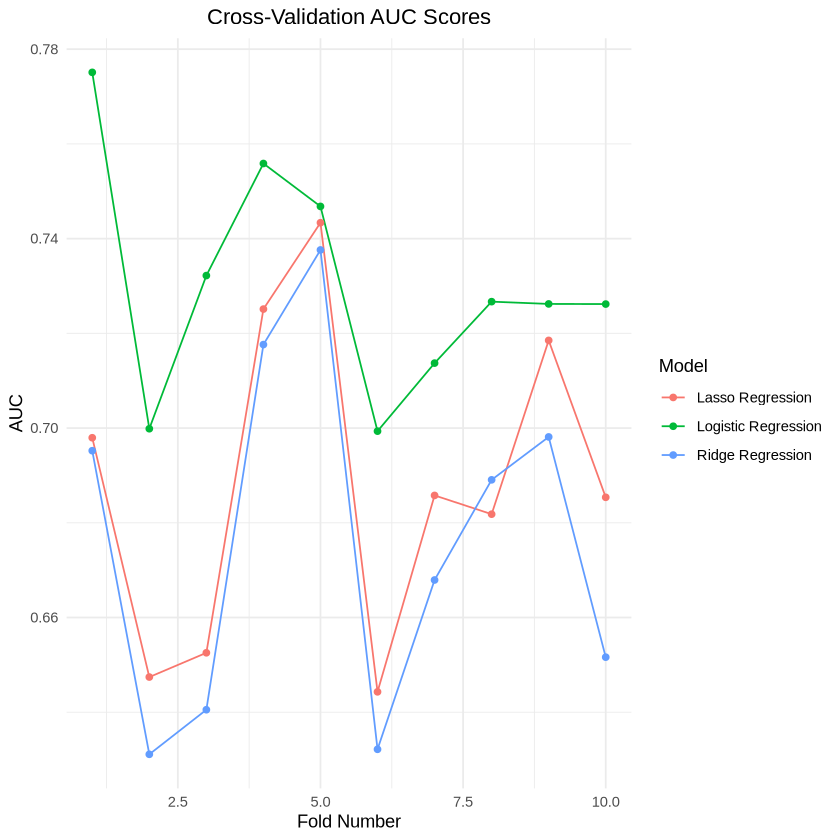

In [ ]:
# Main developer: Ethan Rajkumar
# Contributor: Vivaan Jhaveri, Michael Wang, Ruhani Kaur

# Suppress all warnings
suppressWarnings({
  # Set seed for reproducibility
  set.seed(20010527)
  num.folds <- 10

  # Create folds for cross-validation
  folds <- createFolds(employee_train$LeaveOrNot, k = num.folds)

  # Initialize vectors to store AUC for cross-validation
  logistic_auc <- numeric(num.folds)
  ridge_auc <- numeric(num.folds)
  lasso_auc <- numeric(num.folds)

  for (fold in 1:num.folds) {
    # Train/Test split for the current fold
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]

    # Logistic Regression
    logistic_model <- glm(LeaveOrNot ~ ., data = employee_train, subset = train.idx, family = "binomial")
    logistic_pred <- predict(logistic_model, newdata = employee_train[test.idx, ], type = "response")
    logistic_auc[fold] <- suppressMessages(auc(employee_train$LeaveOrNot[test.idx], logistic_pred))

    # Ridge Regression
    ridge_model <- cv.glmnet(
      x = as.matrix(employee_train[train.idx, -which(names(employee_train) == "LeaveOrNot")]),
      y = employee_train$LeaveOrNot[train.idx],
      alpha = 0, family = "binomial", type.measure = "auc"
    )
    ridge_pred <- predict(ridge_model,
      newx = as.matrix(employee_train[test.idx, -which(names(employee_train) == "LeaveOrNot")]),
      s = "lambda.min", type = "response"
    )
    ridge_auc[fold] <- suppressMessages(auc(employee_train$LeaveOrNot[test.idx], ridge_pred))

    # Lasso Regression
    lasso_model <- cv.glmnet(
      x = as.matrix(employee_train[train.idx, -which(names(employee_train) == "LeaveOrNot")]),
      y = employee_train$LeaveOrNot[train.idx],
      alpha = 1, family = "binomial", type.measure = "auc"
    )
    lasso_pred <- predict(lasso_model,
      newx = as.matrix(employee_train[test.idx, -which(names(employee_train) == "LeaveOrNot")]),
      s = "lambda.min", type = "response"
    )
    lasso_auc[fold] <- suppressMessages(auc(employee_train$LeaveOrNot[test.idx], lasso_pred))
  }

  # Compute the mean AUC for cross-validation
  logistic_cv_auc <- round(mean(logistic_auc), 7)
  ridge_cv_auc <- round(mean(ridge_auc), 7)
  lasso_cv_auc <- round(mean(lasso_auc), 7)

  # Create a tibble for CV results
  cv_results <- tibble(
    Model = rep(c("Logistic Regression", "Ridge Regression", "Lasso Regression"), each = num.folds),
    Fold = rep(1:num.folds, 3),
    AUC = c(logistic_auc, ridge_auc, lasso_auc)
  )

  # Print cross-validation results
  mean_auc <- tibble(
    Model = c("Logistic Regression", "Ridge Regression", "Lasso Regression"),
    Mean_CV_AUC = c(logistic_cv_auc, ridge_cv_auc, lasso_cv_auc)
  )

  print(mean_auc)

  # Plot CV AUC scores
  cv_plot <- ggplot(cv_results, aes(x = Fold, y = AUC, color = Model)) +
    geom_line() +
    geom_point() +
    theme_minimal() +
    labs(
      title = "Cross-Validation AUC Scores",
      x = "Fold Number",
      y = "AUC",
      color = "Model"
    ) +
    theme(plot.title = element_text(hjust = 0.5))

  print(cv_plot)
})

### Retraining models on the full dataset

In [ ]:
# Main developer: Ethan Rajkumar
# Contributor: Vivaan Jhaveri, Michael Wang, Ruhani Kaur
  # -----------------------------------------
  # Retrain All Models on the Full Dataset
  # -----------------------------------------

  # Prepare the data
  x_train <- as.matrix(employee_train[, -which(names(employee_train) == "LeaveOrNot")])
  y_train <- employee_train$LeaveOrNot

  # Prepare the test data
  x_test <- as.matrix(employee_test[, -which(names(employee_test) == "LeaveOrNot")])
  y_test <- employee_test$LeaveOrNot

  # Initialize a list to store models and results
  models <- list()
  test_aucs <- numeric(3)
  coef_dfs <- list()

  # 1. Logistic Regression
  logistic_model_full <- glm(LeaveOrNot ~ ., data = employee_train, family = "binomial")

  # Extract coefficients
  logistic_coef_df <- data.frame(
    Feature = names(coef(logistic_model_full)),
    Coefficient = coef(logistic_model_full)
  )

  # Predict on test set
  logistic_predictions <- predict(logistic_model_full, newdata = employee_test, type = "response")

  # Calculate AUC on test set
  logistic_test_auc <- suppressMessages(auc(y_test, logistic_predictions))
  test_aucs[1] <- logistic_test_auc

  # Generate confusion matrix for logistic regression
  logistic_pred_class <- ifelse(logistic_predictions > 0.5, 1, 0)
  logistic_cm <- confusionMatrix(factor(logistic_pred_class), factor(y_test), positive = "1")

  # Store results
  models$Logistic <- logistic_model_full
  coef_dfs$Logistic <- logistic_coef_df

  # 2. Ridge Regression
  ridge_model_full <- cv.glmnet(
    x = x_train, y = y_train,
    alpha = 0,          # Ridge regression
    family = "binomial",
    type.measure = "auc"
  )

  best_lambda_ridge <- ridge_model_full$lambda.min

  # Extract coefficients
  ridge_coefficients <- coef(ridge_model_full, s = best_lambda_ridge)
  ridge_coef_df <- data.frame(
    Feature = row.names(ridge_coefficients),
    Coefficient = as.vector(ridge_coefficients)
  )

  # Predict on test set
  ridge_predictions <- predict(ridge_model_full, newx = x_test, s = best_lambda_ridge, type = "response")

  # Calculate AUC on test set
  ridge_test_auc <- suppressMessages(auc(y_test, ridge_predictions))
  test_aucs[2] <- ridge_test_auc

  # Generate confusion matrix for ridge regression
  ridge_pred_class <- ifelse(ridge_predictions > 0.5, 1, 0)
  ridge_cm <- confusionMatrix(factor(ridge_pred_class), factor(y_test), positive = "1")

  # Store results
  models$Ridge <- ridge_model_full
  coef_dfs$Ridge <- ridge_coef_df

  # 3. Lasso Regression
  lasso_model_full <- cv.glmnet(
    x = x_train, y = y_train,
    alpha = 1,          # Lasso regression
    family = "binomial",
    type.measure = "auc"
  )

  best_lambda_lasso <- lasso_model_full$lambda.min

  # Extract coefficients
  lasso_coefficients <- coef(lasso_model_full, s = best_lambda_lasso)
  lasso_coef_df <- data.frame(
    Feature = row.names(lasso_coefficients),
    Coefficient = as.vector(lasso_coefficients)
  )

  # Remove zero coefficients (for Lasso)
  lasso_coef_df <- lasso_coef_df[lasso_coef_df$Coefficient != 0, ]

  # Predict on test set
  lasso_predictions <- predict(lasso_model_full, newx = x_test, s = best_lambda_lasso, type = "response")

  # Calculate AUC on test set
  lasso_test_auc <- suppressMessages(auc(y_test, lasso_predictions))
  test_aucs[3] <- lasso_test_auc

  # Generate confusion matrix for lasso regression
  lasso_pred_class <- ifelse(lasso_predictions > 0.5, 1, 0)
  lasso_cm <- confusionMatrix(factor(lasso_pred_class), factor(y_test), positive = "1")

  # Store results
  models$Lasso <- lasso_model_full
  coef_dfs$Lasso <- lasso_coef_df

  # -----------------------------------------
  # Compare Test AUCs
  # -----------------------------------------

  test_auc_df <- tibble(
    Model = c("Logistic Regression", "Ridge Regression", "Lasso Regression"),
    Test_AUC = round(test_aucs, 4)
  )

  print(test_auc_df)

  # -----------------------------------------
  # Print Confusion Matrices
  # -----------------------------------------

  print("Confusion Matrix for Logistic Regression:")
  print(logistic_cm)

  print("Confusion Matrix for Ridge Regression:")
  print(ridge_cm)

  print("Confusion Matrix for Lasso Regression:")
  print(lasso_cm)


# A tibble: 3 × 2
  Model               Test_AUC
  <chr>                  <dbl>
1 Logistic Regression    0.747
2 Ridge Regression       0.687
3 Lasso Regression       0.696
[1] "Confusion Matrix for Logistic Regression:"
Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 561 183
         1  50 137
                                          
               Accuracy : 0.7497          
                 95% CI : (0.7206, 0.7773)
    No Information Rate : 0.6563          
    P-Value [Acc > NIR] : 4.609e-10       
                                          
                  Kappa : 0.3843          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4281          
            Specificity : 0.9182          
         Pos Pred Value : 0.7326          
         Neg Pred Value : 0.7540          
             Prevalence : 0.3437          
         Detection Rate 

### Visualization of coefficients 

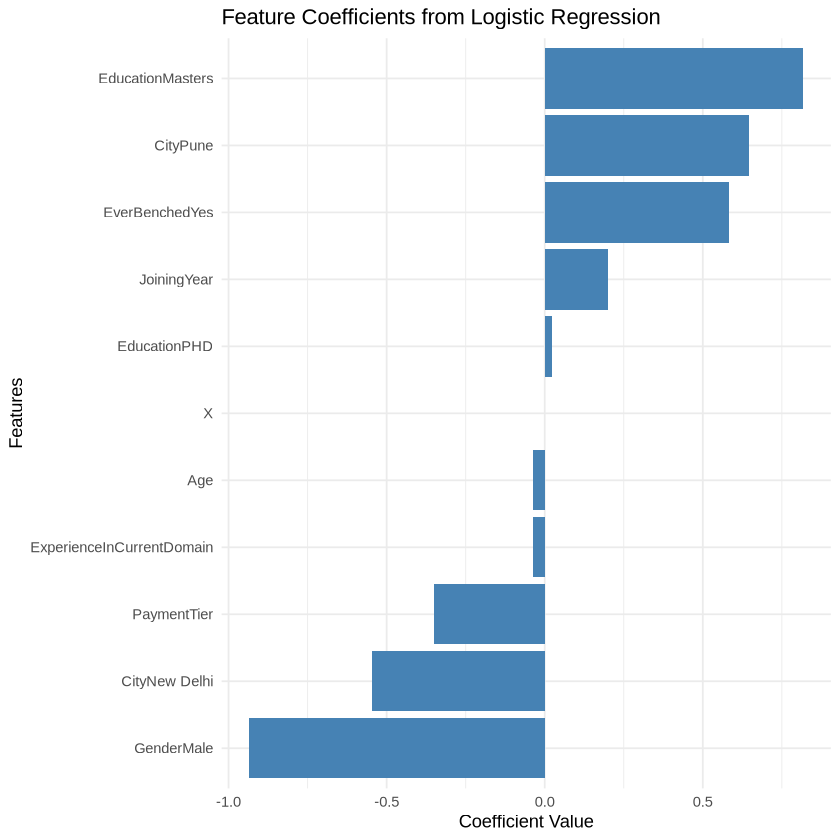

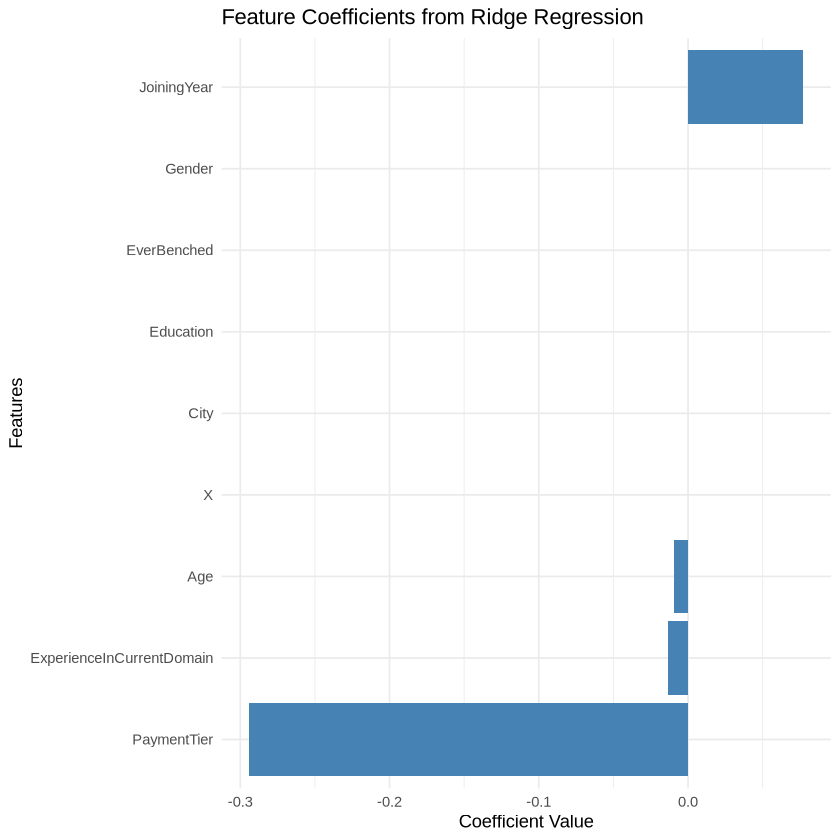

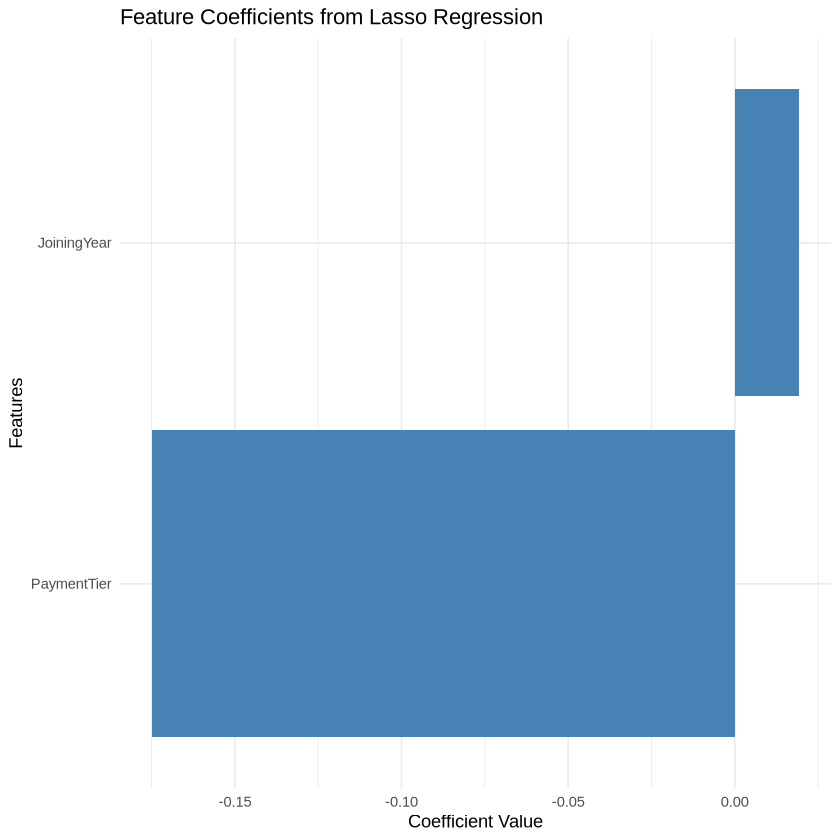

In [ ]:
# Main developer: Ethan Rajkumar
# Contributor: Vivaan Jhaveri, Michael Wang, Ruhani Kaur
  # -----------------------------------------
  # Visualize Coefficients for Each Model
  # -----------------------------------------

  # Function to plot coefficients
  plot_coefficients <- function(coef_df, model_name) {
    # Exclude the intercept for visualization
    coef_plot_df <- coef_df[coef_df$Feature != "(Intercept)", ]

    # Sort by absolute value of coefficients
    coef_plot_df <- coef_plot_df %>%
      mutate(AbsCoefficient = abs(Coefficient)) %>%
      arrange(desc(AbsCoefficient))

    ggplot(coef_plot_df, aes(x = reorder(Feature, Coefficient), y = Coefficient)) +
      geom_bar(stat = "identity", fill = "steelblue") +
      coord_flip() +
      theme_minimal() +
      labs(
        title = paste("Feature Coefficients from", model_name),
        x = "Features",
        y = "Coefficient Value"
      )
  }

  # Plot coefficients for Logistic Regression
  print(plot_coefficients(logistic_coef_df, "Logistic Regression"))

  # Plot coefficients for Ridge Regression
  print(plot_coefficients(ridge_coef_df, "Ridge Regression"))

  # Plot coefficients for Lasso Regression
  print(plot_coefficients(lasso_coef_df, "Lasso Regression"))


## Discussion

In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

Summarize what you found and the implications/impact of your findings.
If relevant, discuss whether your results were what you expected to find.
Discuss how your model could be improved;
Discuss future questions/research this study could lead to.

## References

Alkaabi, A., Alghizzawi, M., Daoud, M. K., & Ezmigna, I. (2024). Factors affecting employee turnover Intention: an integrative perspective. In Studies in systems, decision and control (pp. 737–748). https://doi.org/10.1007/978-3-031-54383-8_57

Alkahtani, A. H. (2015). Investigating Factors that Influence Employees’ Turnover Intention: A Review of Existing Empirical Works. International Journal of Business and Management, 10(12), 152. https://doi.org/10.5539/ijbm.v10n12p152

Employee dataset. (2023, September 6). Kaggle. https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset

Kanchana, L., & Jayathilaka, R. (2023). Factors impacting employee turnover intentions among professionals in Sri Lankan startups. PLoS ONE, 18(2), e0281729. https://doi.org/10.1371/journal.pone.0281729